In [ ]:
!pip install transformers

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the model files back from Google Drive to the Colab instance. 
!cp -r "./drive/My Drive/SemEval2023/t1/models/multi_model_t1_trans/" ./model_save/
#!cp -r "./drive/My Drive/SemEval2023/t1/models/model_t1_firstandlast512/" ./model_save/

!cp -r "./drive/My Drive/SemEval2023/t1/data/" ./

cp: cannot open './drive/My Drive/SemEval2023/t1/data/train_t1_nlp.gsheet' for reading: Operation not supported


In [ ]:
import torch
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()
'''
# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
'''
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
import torch
import keras
from keras_preprocessing.sequence import pad_sequences

def text_to_embedding(tokenizer, model, in_text):
    '''
    Uses the provided BERT `model` and `tokenizer` to generate a vector 
    representation of the input string, `in_text`.

    Returns the vector stored as a numpy ndarray.
    '''

    # ===========================
    #    STEP 1: Tokenization
    # ===========================

    MAX_LEN = 512

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Truncate the sentence to MAX_LEN if necessary.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end. (After truncating!)
    #   (4) Map tokens to their IDs.
    input_ids = tokenizer.encode(
                        in_text,                    # Sentence to encode.
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences.                        
                   )    

    # Pad our input tokens. Truncation was handled above by the `encode`
    # function, which also makes sure that the `[SEP]` token is placed at the
    # end *after* truncating.
    # Note: `pad_sequences` expects a list of lists, but we only have one
    # piece of text, so we surround `input_ids` with an extra set of brackets.
    results = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", 
                              truncating="post", padding="post")
    
    # Remove the outer list.
    input_ids = results[0]

    # Create attention masks    
    attn_mask = [int(i>0) for i in input_ids]
    
    # Cast to tensors.
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    # Add an extra dimension for the "batch" (even though there is only one 
    # input in this batch.)
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)

    # ===========================
    #    STEP 2: BERT Model
    # ===========================

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Copy the inputs to the GPU
    # Note -- I got stuck here for a while because I didn't assign the result 
    # back to the variable! Geez!
    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)
    
    # Telling the model not to build the backwards graph will make this 
    # a little quicker.
    with torch.no_grad():        

        # Forward pass, return hidden states and predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        logits, encoded_layers = model(
                                    input_ids = input_ids, 
                                    #token_type_ids = None, 
                                    attention_mask = attn_mask,
                                    return_dict=False)
        
    # Retrieve our sentence embedding--take the `[CLS]` embedding from the final
    # layer.
    layer_i = 6 # The last BERT layer before the classifier.
    batch_i = 0 # Only one input in the batch.
    token_i = 0 # The first token, corresponding to [CLS]

    #print(len(encoded_layers))    
    # Grab the embedding.
    vec = encoded_layers[layer_i][batch_i][token_i]

    # Move to the CPU and convert to numpy ndarray.
    vec = vec.detach().cpu().numpy()

    return(vec)


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, DistilBertForSequenceClassification,DistilBertTokenizer

# The name of the folder containing the model files.
output_dir = './model_save/'

# Load our fine-tuned model, and configure it to return the "hidden states", 
# from which we will be taking our text embeddings.
model = DistilBertForSequenceClassification.from_pretrained(
    output_dir,
    output_hidden_states = True, # Whether the model returns all hidden-states.
) 

# Load the tokenizer.
tokenizer = DistilBertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
import pandas as pd

print('Parsing the dataset .tsv file...')
data = pd.read_csv('./data/train_t1_nlpfull.csv', index_col = 0)
data_dev = pd.read_csv('./data/dev_t1_nlpfull.csv', index_col = 0)
print('    Done.')


Parsing the dataset .tsv file...
    Done.


In [ ]:
data = data.set_index('id')
data_dev = data_dev.set_index('id')
dev_gold = pd.read_csv('./data/dev_w_headergold.tsv', sep='\t')
dev_gold = dev_gold.set_index('0')
dev_gold.rename(columns = {'1':'type'}, inplace = True)
data_dev =data_dev.join(dev_gold)
data_dev

,type,2,header
0,,,
820791520,reporting,George III Lost America.\n\nTheresa May Could ...,George III Lost America.
821040551,reporting,Queen Elizabeth Would Be Evacuated in Event of...,Queen Elizabeth Would Be Evacuated in Event of...
813552066,reporting,"You insult us, ambassador: Woody Johnson flagr...","You insult us, ambassador: Woody Johnson flagr..."
817176202,reporting,"The British People, as Well as the Politicians...","The British People, as Well as the Politicians..."
820419869,reporting,No break from Brexit: RT takes a look at lates...,No break from Brexit: RT takes a look at lates...
...,...,...,...
829815104,opinion,Brussels Shows Its Fear\n\nHungarian Prime Min...,Brussels Shows Its Fear
817147979,opinion,BREXIT OR BRINO: U.K.\n\nDeep State Strikes Ba...,BREXIT OR BRINO: U.K.
813623212,reporting,'Wishful thinking': Tory MPs dismiss May's hop...,'Wishful thinking': Tory MPs dismiss May's hop...


In [ ]:
import time

# Track the time.
t0 = time.time()

# Store the set of embeddings.
embeddings = []

num_comments = len(data)

print('Generating sentence embeddings for all {:,} documents...'.format(num_comments))

row_num = 0
data['embedding']= ""

# For each row of the dataframe...
for index, row in data.iterrows():

    # Progress update every 2,000 comments.
    if row_num % 50 == 0 and not row_num == 0:

        # Calculate elapsed time and format it.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        rows_per_sec = (time.time() - t0) / row_num
        remaining_sec = rows_per_sec * (num_comments - row_num)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Document {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(row_num, num_comments, elapsed, remaining))

    # Vectorize this comment.
    '''if len(row.text.split())>512:
      print('aca')
    else:'''
    vec = text_to_embedding(tokenizer, model, ' '.join(row.text.split()[-512:]))
    #vec = text_to_embedding(tokenizer, model, ' '.join(row.text.split()[:128] + row.text.split()[-382:])) # first 128 and last 382 tokens
    #print(data.iloc[index]['embedding'])
    data.at[index,'embedding']=vec
    # Store the embeddings.
    embeddings.append(vec) 

    row_num += 1

Generating sentence embeddings for all 54 documents...
  Document      50  of       54.    Elapsed: 0:00:56. Remaining: 0:00:04


In [ ]:
data

,id,text,embedding,Root,NER,POS,Lenght,Punct,Noun,Person,...,PRON,PART,INTJ,n_words,n_words_unique,mean_w_len,n_parag,n_contract,polarity,subjectivity
0,3135,Russian allies are unknowingly working against...,"[0.81912977, -0.47517312, -1.1106197, 0.985576...",working,"[{'Russian': 'NORP'}, {'Ukraine': 'GPE'}, {'St...","{'Russian': 'ADJ', 'allies': 'NOUN', 'are': 'A...",650,8,83,16,...,24,3,0,650,347,4.821538,36,17,0.009776,0.470112
1,3145,Meta Added to Russia’s List of ‘Extremist and ...,"[0.38847953, 0.0938885, -1.1575948, -0.9563148...",declared,"[{'Meta Added': 'PERSON'}, {'Russia': 'GPE'}, ...","{'Meta': 'PROPN', 'Added': 'VERB', 'to': 'PART...",251,7,38,3,...,9,2,0,251,170,5.601594,16,0,-0.083442,0.448701
2,3154,"Oh Thank God, Banksy Is In Ukraine\n\nThe war ...","[0.02060021, -0.6905963, 0.027352743, 1.142599...",Thank,"[{'God': 'PERSON'}, {'Ukraine': 'GPE'}, {'Ukra...","{'Oh': 'INTJ', 'Thank': 'VERB', 'God': 'PROPN'...",400,8,75,5,...,15,4,1,400,253,4.707500,9,0,0.024722,0.486072
3,3111,West uses Ukraine as a testing ground for its ...,"[0.3951324, 0.11370426, -0.18893918, 1.187866,...",uses,"[{'West': 'LOC'}, {'Ukraine': 'GPE'}, {'LPR': ...","{'West': 'PROPN', 'uses': 'VERB', 'Ukraine': '...",385,8,62,1,...,16,3,0,385,224,5.033766,19,0,0.125149,0.361111
4,3125,"Top UN Official . . . ""We Own The Science And ...","[0.56322724, 0.18342645, -0.26117975, 0.677349...",Official,"[{'UN': 'ORG'}, {'We Own The Science And The W...","{'Top': 'ADJ', 'UN': 'PROPN', 'Official': 'PRO...",487,14,57,2,...,15,3,0,487,278,5.151951,33,1,0.279870,0.503102
5,3128,USDA Now Asking People to Register Their Veget...,"[1.2865014, 0.6505651, -0.4102275, 1.1423082, ...",need,"[{'the United States': 'GPE'}, {'USDA': 'ORG'}...","{'USDA': 'PROPN', 'Now': 'ADV', 'Asking': 'VER...",1244,12,212,7,...,22,6,1,1244,669,5.102894,87,0,0.160935,0.447912
6,3110,NESBIT: The US Must Fully Embrace Nuclear Powe...,"[-0.3294847, 0.1801193, -0.33038452, 0.7316103...",NESBIT,"[{'U.S.': 'GPE'}, {'Steve Milloy': 'PERSON'}, ...","{'NESBIT': 'NOUN', ':': 'PUNCT', 'The': 'DET',...",881,10,143,2,...,17,2,0,881,483,5.348468,18,0,0.146809,0.466784
7,316,Global Warmist Bill Gates and His Beach Mansio...,"[0.32011348, -0.6305092, -0.2656321, 1.3467182...",tells,"[{'Bill Gates': 'PERSON'}, {'Bill Gates': 'PER...","{'Global': 'ADJ', 'Warmist': 'PROPN', 'Bill': ...",278,10,55,6,...,15,2,0,278,201,4.888489,15,0,0.076170,0.503792
8,3137,Central Banks Add Gold for Fifth Straight Mont...,"[0.36356434, -0.20529152, -1.0032945, -0.04370...",Add,"[{'the fifth consecutive month': 'DATE'}, {'Au...","{'Central': 'ADJ', 'Banks': 'PROPN', 'Add': 'V...",654,6,66,1,...,8,1,0,654,309,4.683486,36,0,0.031481,0.357534
9,3117,LAB ORIGIN THEORY CONFIRMED: Trump adviser Deb...,"[0.77889687, -0.1186934, -0.03668109, 0.981645...",CONFIRMED,"[{'Trump': 'ORG'}, {'Deborah Birx': 'PERSON'},...","{'LAB': 'NOUN', 'ORIGIN': 'PROPN', 'THEORY': '...",608,10,69,13,...,22,4,0,608,334,4.896382,37,0,0.131164,0.438325


In [ ]:
X = data[['Lenght',
 'Punct',
 'Noun',
 'Person',
 'Organization',
 'Geopolitical',
 'ADJ',
 'ADP',
 'PROPN',
 'AUX',
 'VERB',
 'SPACE',
 'DET',
 'CCONJ',
 'ADV',
 'SCONJ',
 'NUM',
 'PRON',
 'PART',
 'INTJ',
 'n_words',
 'n_words_unique',
 #'n_stopwords',
 #'n_punct',
 'mean_w_len',
 'n_parag',
 'polarity',
 'subjectivity']]


In [ ]:
y = data_full[["type"]]

In [ ]:
df = data.embedding.apply(pd.Series)
result = pd.concat([X,df], axis=1)
result

,Lenght,Punct,Noun,Person,Organization,Geopolitical,ADJ,ADP,PROPN,AUX,...,758,759,760,761,762,763,764,765,766,767
0,650,8,83,16,6,17,42,21,25,16,...,0.522886,0.069984,-0.418888,0.033322,-0.309978,-0.235242,-0.308442,-0.700893,-1.342850,-0.054773
1,251,7,38,3,14,11,11,14,24,5,...,-0.099197,1.119508,0.621265,0.616366,-0.079077,1.224418,0.039605,-1.057738,0.390489,0.412876
2,400,8,75,5,1,8,30,18,9,16,...,0.478200,0.116144,-0.703519,-0.463158,0.023525,-1.226831,-0.352844,-0.552427,-1.253991,-0.093087
3,385,8,62,1,3,10,25,10,19,13,...,-0.188538,-0.218088,-0.074032,-0.476819,-0.140533,-0.198783,-0.069618,-0.411731,-0.957063,-0.859533
4,487,14,57,2,32,2,21,17,40,12,...,0.685793,-0.456401,-0.181376,-0.518090,0.234960,-0.667576,-0.673909,-0.215754,-0.334648,0.533290
5,1244,12,212,7,31,4,65,33,69,17,...,0.412134,-0.521191,-0.053397,0.381530,0.338286,0.252255,-0.882824,-1.187717,-0.394345,-0.475278
6,881,10,143,2,5,20,82,25,35,12,...,0.620767,0.465562,0.298190,0.013136,0.473259,-0.352312,-0.556680,-0.718497,-0.806033,-0.226515
7,278,10,55,6,3,3,23,12,20,9,...,0.449470,0.253923,-0.627283,-0.322951,0.112429,-1.983781,-0.730260,-0.771649,-0.807827,0.178141
8,654,6,66,1,11,14,39,22,29,10,...,0.178929,0.557095,0.209548,0.084757,0.133350,1.469326,0.372113,-1.459793,-0.005445,-0.295484
9,608,10,69,13,5,9,31,17,20,14,...,0.759339,-0.520228,-1.047090,-0.487750,0.214889,-1.115126,-0.356092,0.137403,-0.450811,-0.460037


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(result, y, stratify=y,random_state=1)
scaler= StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))
#X_train = #X_train[:].values


#class_weights = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.type)
#class_weights = dict(enumerate(class_weights))

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
y_train.value_counts()

1        
reporting    40
opinion      15
satire        7
dtype: int64

In [ ]:
y_train_res.value_counts()

1        
opinion      40
reporting    40
satire       40
dtype: int64

In [ ]:
##MLP
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 

clf = MLPClassifier(hidden_layer_sizes=(195, 48, 12), max_iter=300,activation = 'relu',solver='adam',random_state=1).fit(X_train, y_train)#195, 48, 12
y_pred_mlp=clf.predict(X_test[:])

cm = confusion_matrix(y_pred_mlp, y_test)

print(cm)

print(classification_report(y_pred_mlp, y_test))

print('ACC',accuracy_score(y_pred_mlp, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[86 14  2]
 [14 43  1]
 [ 0  2 15]]
              precision    recall  f1-score   support

     opinion       0.86      0.84      0.85       102
   reporting       0.73      0.74      0.74        58
      satire       0.83      0.88      0.86        17

    accuracy                           0.81       177
   macro avg       0.81      0.82      0.81       177
weighted avg       0.81      0.81      0.81       177

ACC 0.8135593220338984


In [ ]:
from sklearn import svm
clf2= svm.SVC(kernel='linear', class_weight='balanced', probability=True).fit(X_train, y_train) #,class_weight=class_weights
y_pred_svm=clf2.predict(X_test[:].values)
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 

cm = confusion_matrix(y_pred_svm, y_test)
print(cm)

print(classification_report(y_pred_svm, y_test))

print('ACC',accuracy_score(y_pred_svm, y_test))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[[78 18  2]
 [18 41  2]
 [ 4  0 14]]
              precision    recall  f1-score   support

     opinion       0.78      0.80      0.79        98
   reporting       0.69      0.67      0.68        61
      satire       0.78      0.78      0.78        18

    accuracy                           0.75       177
   macro avg       0.75      0.75      0.75       177
weighted avg       0.75      0.75      0.75       177

ACC 0.751412429378531


In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf= RandomForestClassifier(class_weight='balanced', random_state=1, max_depth=5, n_estimators=10, max_features=1)
model_rf.fit(X_train_res, y_train_res)
y_pred_rf=model_rf.predict(X_test[:].values)

cm = confusion_matrix(y_pred_rf, y_test)
print(cm)

print(classification_report(y_pred_rf, y_test))
print('ACC',accuracy_score(y_pred_rf, y_test))

[[73  8  1]
 [19 35  0]
 [ 4  2 15]]
              precision    recall  f1-score   support

     opinion       0.76      0.89      0.82        82
   reporting       0.78      0.65      0.71        54
      satire       0.94      0.71      0.81        21

    accuracy                           0.78       157
   macro avg       0.83      0.75      0.78       157
weighted avg       0.79      0.78      0.78       157

ACC 0.7834394904458599


<ipython-input-100-47021b168dfd>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train_res, y_train_res)


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model_ada= AdaBoostClassifier(learning_rate=0.01)
model_ada.fit(X_train_res, y_train_res)
y_pred_ada=model_ada.predict(X_test[:].values)

cm = confusion_matrix(y_pred_ada, y_test)
print(cm)

print(classification_report(y_pred_ada, y_test))
print('ACC',accuracy_score(y_pred_ada, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[78 17  3]
 [13 28  0]
 [ 5  0 13]]
              precision    recall  f1-score   support

     opinion       0.81      0.80      0.80        98
   reporting       0.62      0.68      0.65        41
      satire       0.81      0.72      0.76        18

    accuracy                           0.76       157
   macro avg       0.75      0.73      0.74       157
weighted avg       0.76      0.76      0.76       157

ACC 0.7579617834394905


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 9.9 MB/s eta 0:00:00


In [ ]:
import shap
#import nlp
import torch
import numpy as np
import scipy as sp
from shap.plots import waterfall
explainer = shap.KernelExplainer(clf.predict_proba,X)
shap_values = explainer.shap_values(X,approximate=True)

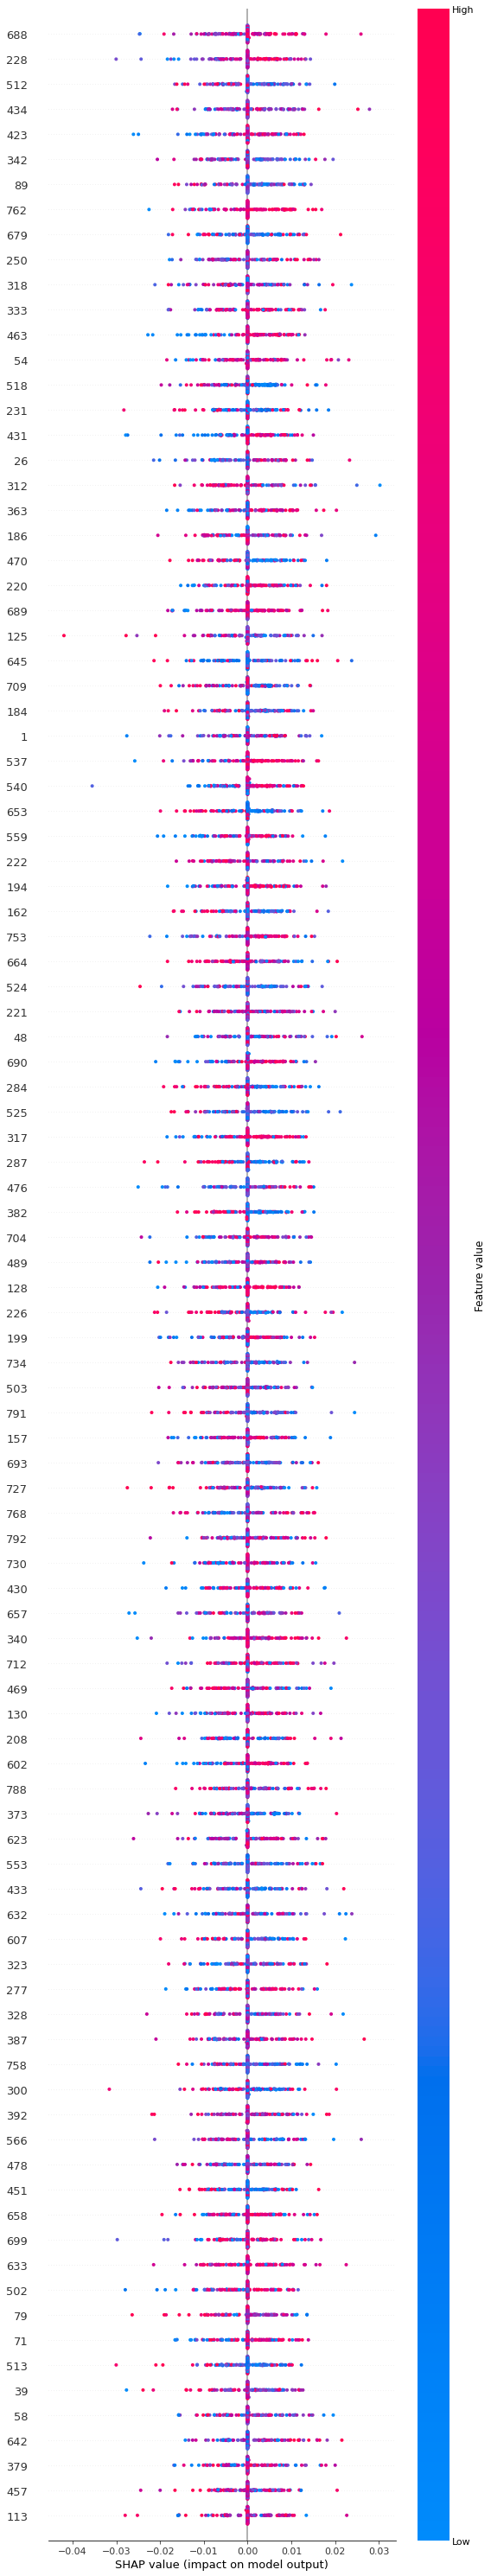

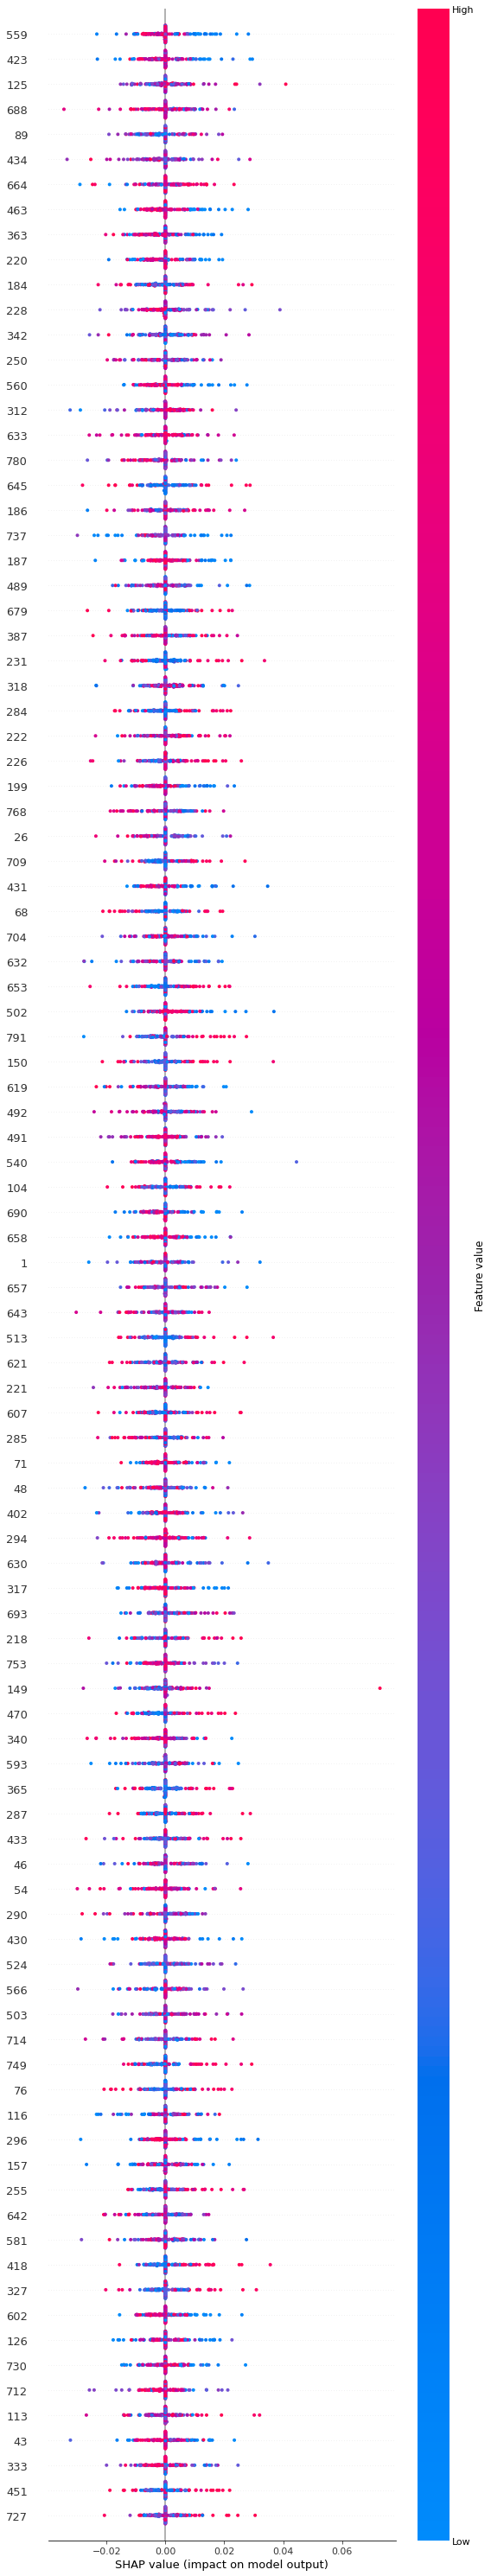

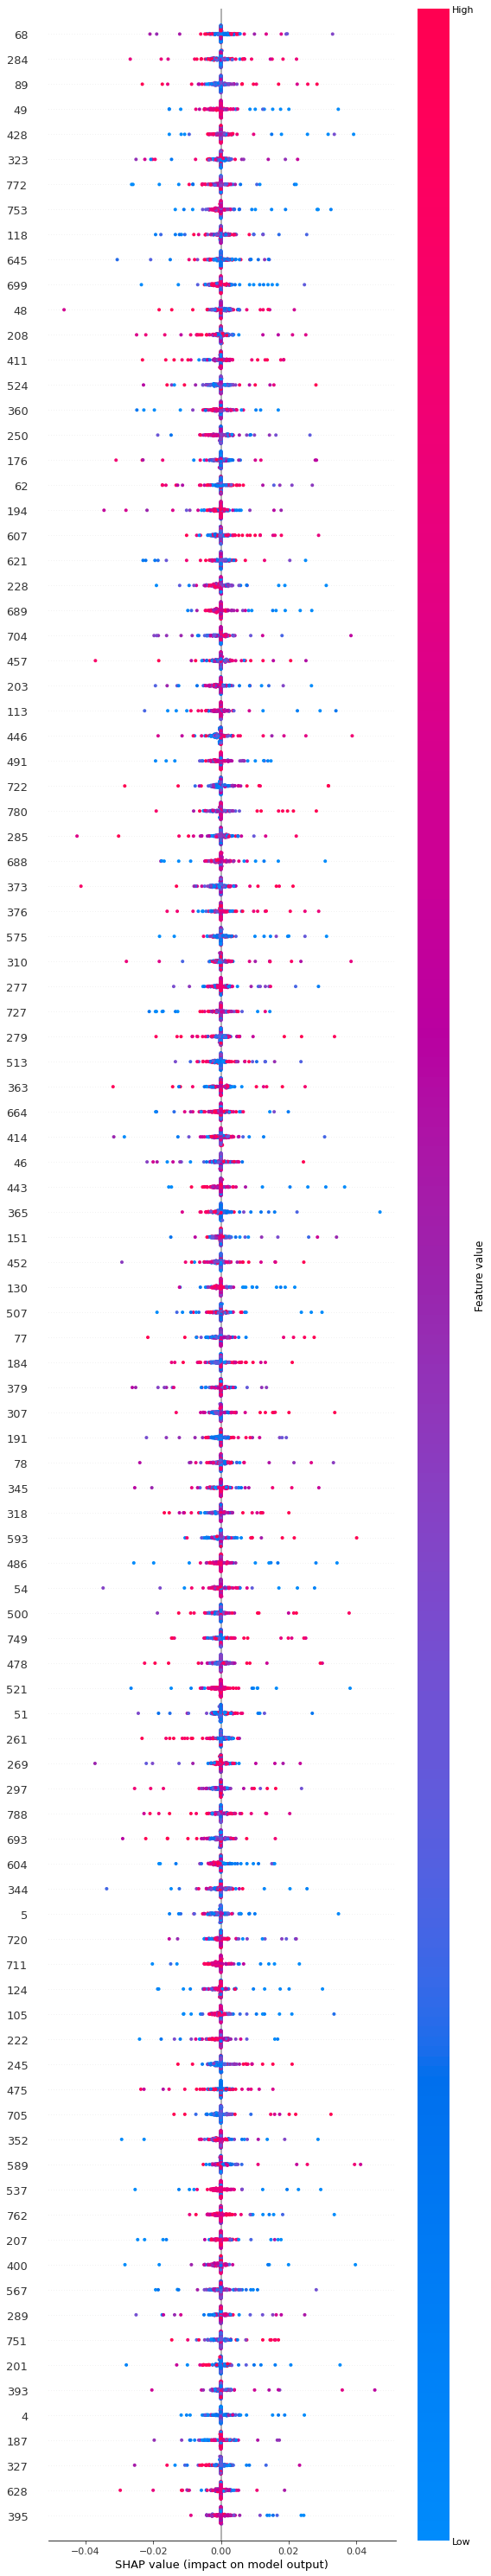

In [ ]:
#all features with end of text
shap.summary_plot(shap_values[0], X_test,max_display=100)
shap.summary_plot(shap_values[1], X_test,max_display=100)
shap.summary_plot(shap_values[2], X_test,max_display=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbf33d81f0>]],
      dtype=object)

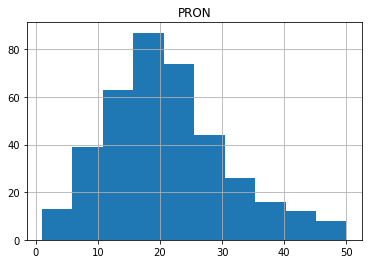

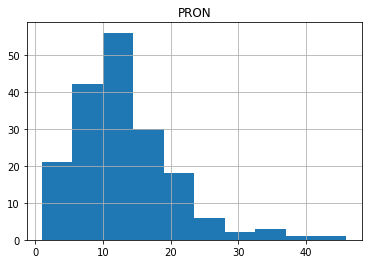

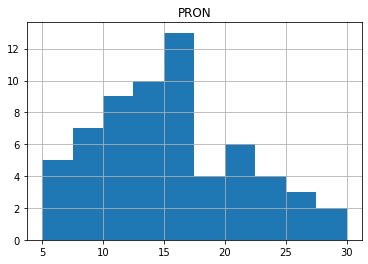

In [ ]:
data[data['type']=='opinion'].hist(column='PRON')
data[data['type']=='reporting'].hist(column='PRON')
data[data['type']=='satire'].hist(column='PRON')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbfbf91c10>]],
      dtype=object)

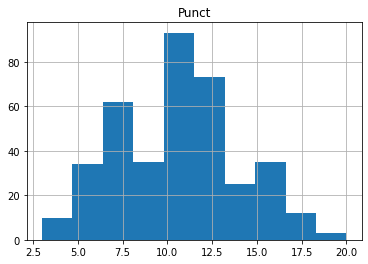

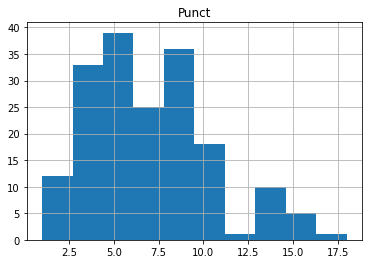

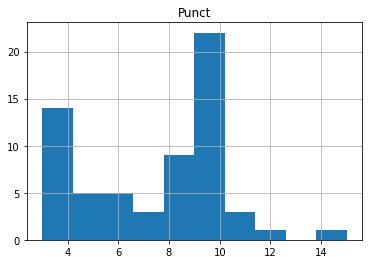

In [ ]:
data[data['type']=='opinion'].hist(column='Punct')
data[data['type']=='reporting'].hist(column='Punct')
data[data['type']=='satire'].hist(column='Punct')


##NLP - Feature Extraction

In [ ]:
import spacy
from nltk.tokenize.punkt import PunktSentenceTokenizer
nlp = spacy.load("en_core_web_sm") # don't need NER, can disable

def root(text): # RETURN ROOT
    doc = nlp(text)

    dependency_features = ['Id', 'Text', 'Head', 'Dep']
    head_format = "\033[1m{!s:>11}\033[0m" * (len(dependency_features) )
    row_format = "{!s:>11}" * (len(dependency_features) ) 
    for token in doc:
        if token.dep_=="ROOT":
            return token.text
        
def ner(text): 
    doc = nlp(text)
    a=list()
    for ent in doc.ents:
        dictio=dict()
        dictio[ent.text]=ent.label_
        a.append(dictio)
    return a 

def sents_token_bounds(text):
    sents_starts = []
    for start, end in PunktSentenceTokenizer().span_tokenize(text):
        sents_starts.append(start)
    sents_starts.append(100000)
    return np.array(sents_starts)

def clear(text):
    return text.strip().replace('\t', ' ').replace('\n', ' ').replace("\'", "'")

def get_context(article, span_start, span_end):
    bounds = sents_token_bounds(article)
    context_start = bounds[np.where(bounds <= span_start)[0][-1]]
    context_end = bounds[np.where(bounds >= span_end)[0][0]]
    return clear(article[context_start:context_end])

def rule2_mod(text,index):
    doc = nlp(text)
    phrase = '' 
    for token in doc: 
        if token.i == index:
            for subtoken in token.children:
                if (subtoken.pos_ == 'ADJ'):
                    phrase += ' '+subtoken.text
            break 
    return phrase
# rule 1 modified function

def rule1_mod(text): 
    doc = nlp(text)
    sent = []
    for token in doc:
        # root word
        if (token.pos_=='VERB'):
            phrase =''
            # only extract noun or pronoun subjects
            for sub_tok in token.lefts:
                if (sub_tok.dep_ in ['nsubj','nsubjpass']) and (sub_tok.pos_ in ['NOUN','PROPN','PRON']):
                    # look for subject modifier
                    adj = rule2_mod(text,sub_tok.i)
                    phrase += adj + ' ' + sub_tok.text
                    # save the root word of the word
                    phrase += ' '+token.lemma_ 
                    # check for noun or pronoun direct objects
                    for sub_tok in token.rights:                   
                        if (sub_tok.dep_ in ['dobj']) and (sub_tok.pos_ in ['NOUN','PROPN']):                          
                            # look for object modifier
                            adj = rule2_mod(text,sub_tok.i)                          
                            phrase += adj+' '+sub_tok.text
                            sent.append(phrase)        
    return sent

# rule 3 function
def rule3(text):   
    doc = nlp(text)
    sent = []
    for token in doc:
        # look for prepositions
        if token.pos_=='ADP':
            phrase = ''
            # if its head word is a noun
            if token.head.pos_=='NOUN':
                # append noun and preposition to phrase
                phrase += token.head.text
                phrase += ' '+token.text
                # check the nodes to the right of the preposition
                for right_tok in token.rights:
                    # append if it is a noun or proper noun
                    if (right_tok.pos_ in ['NOUN','PROPN']):
                        phrase += ' '+right_tok.text
                if len(phrase)>2:
                    sent.append(phrase)
    return sent

# rule 3 function
def rule4(text):   
    doc = nlp(text)
    sent = []
    for token in doc:
        # look for prepositions
        if token.pos_=='ADJ':
            phrase = ''
            # if its head word is a noun
            if token.head.pos_=='NOUN':
                # append noun and preposition to phrase
                phrase += token.head.text
                phrase += ' '+token.text
                # check the nodes to the right of the preposition
                for right_tok in token.rights:
                    # append if it is a noun or proper noun
                    if (right_tok.pos_ in ['NOUN','PROPN']):
                        phrase += ' '+right_tok.text
                if len(phrase)>2:
                    sent.append(phrase)
    return sent


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
data = data_test

In [ ]:
data = data.reset_index()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

data["Root"]=""
data["NER"]=""
data["POS"]=""
for i in range(len(data)):
    print(i)
    data.iloc[i, data.columns.get_loc("Root")]=root(data.iloc[i].text)
    data.at[i, "NER"]=ner(data.iloc[i].text)

for i in range(len(data)):
  print(i)
  text = list(nlp(data.iloc[i].text))
  pos_art=dict()
  for token in text:
      pos_art[token.text]=token.pos_
  data.loc[i, "POS"]=[pos_art]

data["Lenght"]=0

for j in range(len(data)):
    print(j)
    data.loc[j,"Lenght"]=len(data.loc[j, "text"].split())

data["Punct"]=0
data["Noun"]=0
for i in range(len(data)):
    print(i)
    count_punct_art=0
   
    count_noun_art=0

    for j in data.loc[i, "POS"]:
        if data.loc[i, "POS"][j]=="PUNCT":
            count_punct_art+=1
        elif data.loc[i, "POS"][j]=="NOUN":
            count_noun_art+=1

    data.loc[i, "Punct"]=count_punct_art

    data.loc[i, "Noun"]=count_noun_art

data["Person"]=0
data["Organization"]=0
data["Geopolitical"]=0

for i in range(len(data)):
    person_art=0
    org_art=0
    geo_art=0
    for z in range(len(data.loc[i, "NER"])):
        for k in data.loc[i, "NER"][z]:
            if data.loc[i, "NER"][z][k]=="PERSON":
                person_art+=1
            elif data.loc[i, "NER"][z][k]=="GPE":
                geo_art+=1
            elif data.loc[i, "NER"][z][k]=="ORG":
                org_art+=1
    data.loc[i, "Person"]=person_art
    data.loc[i, "Organization"]=org_art
    data.loc[i, "Geopolitical"]=geo_art

data["ADJ"]=0

for i in range(len(data)):
    adj_art=0
    
    for j in data.loc[i, "POS"]:
        if data.loc[i, "POS"][j]=="ADJ":
            adj_art+=1

    data.loc[i, "ADJ"]=adj_art

data["ADP"]=0
data["PROPN"]=0
data["AUX"]=0
data["VERB"]=0
data["SPACE"]=0
data["DET"]=0
data["CCONJ"]=0
data["ADV"]=0
data["SCONJ"]=0
data["NUM"]=0
data["PRON"]=0
data["PART"]=0
data["INTJ"]=0

for i in range(len(data)):
    adj_art=0
    prop_spa=0
    aux_spa=0
    verb_spa=0
    spa_spa=0
    det_spa=0
    cconj_spa=0
    adv_spa=0
    sconj_spa=0
    num_spa=0
    pron_spa=0
    part_spa=0
    intj_spa=0
    
    for j in data.loc[i, "POS"]:
        if data.loc[i, "POS"][j]=="ADP":
            adj_art+=1
        elif data.loc[i, "POS"][j]=="PROPN":
            prop_spa+=1
        elif data.loc[i, "POS"][j]=="AUX":
            aux_spa+=1
        elif data.loc[i, "POS"][j]=="VERB":
            verb_spa+=1
        elif data.loc[i, "POS"][j]=="SPACE":
            spa_spa+=1
        elif data.loc[i, "POS"][j]=="DET":
            det_spa+=1 
        elif data.loc[i, "POS"][j]=="CCONJ":
            cconj_spa+=1
        elif data.loc[i, "POS"][j]=="ADV":
            adv_spa+=1
        elif data.loc[i, "POS"][j]=="SCONJ":
            sconj_spa+=1
        elif data.loc[i, "POS"][j]=="NUM":
            num_spa+=1
        elif data.loc[i, "POS"][j]=="PRON":
            pron_spa+=1
        elif data.loc[i, "POS"][j]=="PART":
            part_spa+=1
        elif data.loc[i, "POS"][j]=="INTJ":
            intj_spa+=1
            
    data.loc[i, "ADP"]=adj_art
    data.loc[i, "PROPN"]=prop_spa
    data.loc[i, "AUX"]=aux_spa
    data.loc[i, "VERB"]=verb_spa
    data.loc[i, "SPACE"]=spa_spa
    data.loc[i, "DET"]=det_spa
    data.loc[i, "CCONJ"]=cconj_spa
    data.loc[i, "ADV"]=adv_spa
    data.loc[i, "SCONJ"]=sconj_spa
    data.loc[i, "NUM"]=num_spa
    data.loc[i, "PRON"]=pron_spa
    data.loc[i, "PART"]=part_spa
    data.loc[i, "INTJ"]=intj_spa

data["n_words"]=data['text'].apply(lambda x: len(str(x).split()))
data["n_words_unique"]=data['text'].apply(lambda x: len(set(str(x).split())))
#data["n_stopwords"]=data['text'].apply(lambda x: len([w for w in str(x).split() if w in stopwords.words('english')]))
#data["n_punct"]=data['text'].apply(lambda x: len([w for w in str(x) if w in list(string.punctuation)]))
data["mean_w_len"]=data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
data["n_parag"]=data['text'].apply(lambda x: len(x.split('\n')))

import re
def conntractionsCount(text):
  count = 0
  count += re.subn(r"n\'t",'', text)[1]
  count += re.subn(r"\'re",'', text)[1]
  count += re.subn(r"\'s",'', text)[1]
  count += re.subn(r"\'ll",'', text)[1]
  count += re.subn(r"\'t",'', text)[1]
  count += re.subn(r"\'ve",'', text)[1]
  count += re.subn(r"\'m",'', text)[1]
  return count

data["n_contract"]= data['text'].apply(conntractionsCount)

from textblob import TextBlob
data["polarity"]= data['text'].apply(lambda x: TextBlob(x).sentiment[0])
data["subjectivity"]= data['text'].apply(lambda x: TextBlob(x).sentiment[1])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [ ]:
data

,id,text,embedding,Root,NER,POS,Lenght,Punct,Noun,Person,...,PRON,PART,INTJ,n_words,n_words_unique,mean_w_len,n_parag,n_contract,polarity,subjectivity
0,3135,Russian allies are unknowingly working against...,"[0.81912977, -0.47517312, -1.1106197, 0.985576...",working,"[{'Russian': 'NORP'}, {'Ukraine': 'GPE'}, {'St...","{'Russian': 'ADJ', 'allies': 'NOUN', 'are': 'A...",650,8,83,16,...,24,3,0,650,347,4.821538,36,17,0.009776,0.470112
1,3145,Meta Added to Russia’s List of ‘Extremist and ...,"[0.38847953, 0.0938885, -1.1575948, -0.9563148...",declared,"[{'Meta Added': 'PERSON'}, {'Russia': 'GPE'}, ...","{'Meta': 'PROPN', 'Added': 'VERB', 'to': 'PART...",251,7,38,3,...,9,2,0,251,170,5.601594,16,0,-0.083442,0.448701
2,3154,"Oh Thank God, Banksy Is In Ukraine\n\nThe war ...","[0.02060021, -0.6905963, 0.027352743, 1.142599...",Thank,"[{'God': 'PERSON'}, {'Ukraine': 'GPE'}, {'Ukra...","{'Oh': 'INTJ', 'Thank': 'VERB', 'God': 'PROPN'...",400,8,75,5,...,15,4,1,400,253,4.707500,9,0,0.024722,0.486072
3,3111,West uses Ukraine as a testing ground for its ...,"[0.3951324, 0.11370426, -0.18893918, 1.187866,...",uses,"[{'West': 'LOC'}, {'Ukraine': 'GPE'}, {'LPR': ...","{'West': 'PROPN', 'uses': 'VERB', 'Ukraine': '...",385,8,62,1,...,16,3,0,385,224,5.033766,19,0,0.125149,0.361111
4,3125,"Top UN Official . . . ""We Own The Science And ...","[0.56322724, 0.18342645, -0.26117975, 0.677349...",Official,"[{'UN': 'ORG'}, {'We Own The Science And The W...","{'Top': 'ADJ', 'UN': 'PROPN', 'Official': 'PRO...",487,14,57,2,...,15,3,0,487,278,5.151951,33,1,0.279870,0.503102
5,3128,USDA Now Asking People to Register Their Veget...,"[1.2865014, 0.6505651, -0.4102275, 1.1423082, ...",need,"[{'the United States': 'GPE'}, {'USDA': 'ORG'}...","{'USDA': 'PROPN', 'Now': 'ADV', 'Asking': 'VER...",1244,12,212,7,...,22,6,1,1244,669,5.102894,87,0,0.160935,0.447912
6,3110,NESBIT: The US Must Fully Embrace Nuclear Powe...,"[-0.3294847, 0.1801193, -0.33038452, 0.7316103...",NESBIT,"[{'U.S.': 'GPE'}, {'Steve Milloy': 'PERSON'}, ...","{'NESBIT': 'NOUN', ':': 'PUNCT', 'The': 'DET',...",881,10,143,2,...,17,2,0,881,483,5.348468,18,0,0.146809,0.466784
7,316,Global Warmist Bill Gates and His Beach Mansio...,"[0.32011348, -0.6305092, -0.2656321, 1.3467182...",tells,"[{'Bill Gates': 'PERSON'}, {'Bill Gates': 'PER...","{'Global': 'ADJ', 'Warmist': 'PROPN', 'Bill': ...",278,10,55,6,...,15,2,0,278,201,4.888489,15,0,0.076170,0.503792
8,3137,Central Banks Add Gold for Fifth Straight Mont...,"[0.36356434, -0.20529152, -1.0032945, -0.04370...",Add,"[{'the fifth consecutive month': 'DATE'}, {'Au...","{'Central': 'ADJ', 'Banks': 'PROPN', 'Add': 'V...",654,6,66,1,...,8,1,0,654,309,4.683486,36,0,0.031481,0.357534
9,3117,LAB ORIGIN THEORY CONFIRMED: Trump adviser Deb...,"[0.77889687, -0.1186934, -0.03668109, 0.981645...",CONFIRMED,"[{'Trump': 'ORG'}, {'Deborah Birx': 'PERSON'},...","{'LAB': 'NOUN', 'ORIGIN': 'PROPN', 'THEORY': '...",608,10,69,13,...,22,4,0,608,334,4.896382,37,0,0.131164,0.438325
